# Train an initail model
First train a model on the data as it is. There will be many mis-labelled samples in here, so the model won't be great, but we can use it later to clean the training and validation data. 

In [11]:
wandb_description = "Initial model using the un-verified training data, with 1000 samples from each class"

In [12]:
# !pip install wandb
# ! pip install wandb --upgrade

In [86]:
# imports
import wandb
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df, plot_metrics_across_thresholds
# import src.data
# import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
from opensoundscape.data_selection import resample
import numpy as np
# import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
# import torch
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# If training on a Mac:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


# Set some hyperparameters

In [35]:
n_samples_per_class = 1000
n_samples_per_class_validation = 100
random_seed = 42
learning_rate = 0.001
epochs=10

### DataFrame (df): The primary Pandas data structure. Used for containing and manipulating 2 dimensional data (data with rows and cols).

In [26]:
# load training and validation dataframes
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_set.pkl")
train_df.head()

recording_url  \
file                                              start_time end_time                                                      
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  1.5        4.5       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  3.0        6.0       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  4.5        7.5       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  6.0        9.0       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   

                                                                      task_method  \
file                                              start_time end_time               
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0             1SPM   
                                                  1.5        4.5             1SPM   
                                                  3.0        6.0             1SPM   
                                                  4.5        7.5             1SPM   
                                                  6.0        9.0             1SPM   

                                                                                                   project  \
file                                              start_time end_time                                        
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0       Boreal Wetland Community Monitoring   
                                                  1.5        4.5       Boreal Wetland Community Monitoring   
                                                  3.0        6.0       Boreal Wetland Community Monitoring   
                                                  4.5        7.5       Boreal Wetland Community Monitoring   
                                                  6.0        9.0       Boreal Wetland Community Monitoring   

                                                                              detection_time  \
file                                              start_time end_time                          
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0       [7.65, 107.76, 173.1]   
                                                  1.5        4.5       [7.65, 107.76, 173.1]   
                                                  3.0        6.0       [7.65, 107.76, 173.1]   
                                                  4.5        7.5       [7.65, 107.76, 173.1]   
                                                  6.0        9.0       [7.65, 107.76, 173.1]   

                                                                             tag_duration  \
file                                              start_time end_time                       
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0       [0.71, 0.59, 0.69]   
                                                  1.5        4.5       [0.71, 0.59, 0.69]   
                                                  3.0        6.0       [0.71, 0.59, 0.69]   
                                                  4.5        7.5       [0.71, 0.59, 0.69]   
                                                  6.0        9.0       [0.71, 0.59, 0.69]   

                                                                        latitude  \
file                                              start_time end_time              
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0       57.307244   
                                                  1.5        4.5       57.307244   
                                                  3.0        6.0       57.307244   
                                                  4.5        7.5       57.307244   
                                          

### Dataset (ds): PyTorch lingo for a pairing of the inputs with the targets.
The only feature needed for training alongside the input spectrogram is the present / absent label. So we can drop the remaining columns from the dataframe to make things neater. 

In [27]:
# Create datasets
train_ds = train_df[['target_present']]
valid_ds = valid_df[['target_present']]
train_ds.head()

target_present
file                                              start_time end_time                
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0                  0.0
                                                  1.5        4.5                  0.0
                                                  3.0        6.0                  0.0
                                                  4.5        7.5                  0.0
                                                  6.0        9.0                  1.0

In [29]:
train_ds.value_counts()

target_present
0.0               36377
1.0                3303
Name: count, dtype: int64

In [43]:
# Take a sample of 1000 samples from each class for training the initial model. 

def sample_data(df, n_samples_per_class, random_seed):
    present = df[df['target_present'] == 1].sample(n=n_samples_per_class, random_state=random_seed)
    absent = df[df['target_present'] == 0].sample(n=n_samples_per_class, random_state=random_seed)
    return pd.concat([present, absent]).sample(frac=1, random_state=random_seed)

train_ds = sample_data(train_ds, n_samples_per_class, random_seed)
valid_ds = sample_data(valid_ds, n_samples_per_class_validation, random_seed)

train_ds.target_present.value_counts()

target_present
0.0    1000
1.0    1000
Name: count, dtype: int64

# Define a model architecture to train. 

In [79]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 (faster) or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_ds.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
    
)

# Single target means that there can only be one label present at any time. For multi class problems this could be set to true or false depending on whether there are multiple simultaneous labels. For binary problem it should be set to false to enable sigmoid activation at the final layer. 
model.single_target = False
model.optimizer_params['lr'] = learning_rate

model.classes

['target_present']

Look at some samples from the database. There will probably be some mis-labelled samples in here, but we should see plenty of the target species vocalization too. 

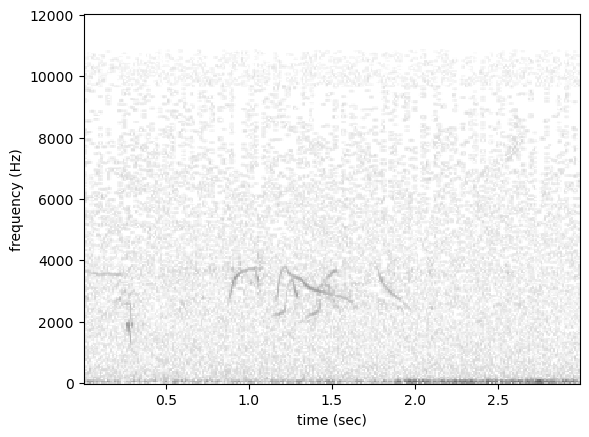

In [80]:
# ctrl + enter to cycle through samples from the dataset. Choose present or absent. 
show_sample_from_df(train_ds, label='present')

In [82]:
# Make sure you're using the GPU - it should say 'cuda' if you are on a pc and 'mps' on a mac. 
print(f'model.device is: {model.device}')

model.device is: mps


# Weights & Biases initialization
Weights and biases is used to track the progress during model training, and to compare different models with one-another. 

In [88]:
# Passing in the name of the current notebook here.
%set_env WANDB_NOTEBOOK_NAME={Path.cwd()}/3-train-a-small-model

wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=wandb_description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "n_samples_per_class_validation": n_samples_per_class_validation,
    "random_seed": random_seed,    }
)
wandb.config.learning_rate = learning_rate

env: WANDB_NOTEBOOK_NAME=/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/presentation_nbs/3-train-a-small-model


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


# Train the model

In [89]:
# Train the model
model.train(
    train_ds,
    valid_ds,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, # parallelized cpu tasks for prep. Reduce if dataloader quits unexpectedly. 
    log_interval = 100,
    save_interval = 10,
    save_path=model_save_path,
    invalid_samples_log="./invalid_samples.log",
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 [batch 0/32, 0.00%] 
	DistLoss: 0.679
Metrics:
Metrics:
	MAP: 0.502

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.556

Training Epoch 1


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 [batch 0/32, 0.00%] 
	DistLoss: 0.679
Metrics:
Metrics:
	MAP: 0.525

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.531

Training Epoch 2


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 [batch 0/32, 0.00%] 
	DistLoss: 0.697
Metrics:
Metrics:
	MAP: 0.582

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.621

Training Epoch 3


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 [batch 0/32, 0.00%] 
	DistLoss: 0.653
Metrics:
Metrics:
	MAP: 0.629

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.701

Training Epoch 4


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 [batch 0/32, 0.00%] 
	DistLoss: 0.645
Metrics:
Metrics:
	MAP: 0.699

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.775

Training Epoch 5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 [batch 0/32, 0.00%] 
	DistLoss: 0.547
Metrics:
Metrics:
	MAP: 0.755

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.812

Training Epoch 6


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 [batch 0/32, 0.00%] 
	DistLoss: 0.565
Metrics:
Metrics:
	MAP: 0.790

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.870

Training Epoch 7


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 [batch 0/32, 0.00%] 
	DistLoss: 0.545
Metrics:
Metrics:
	MAP: 0.841

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.909

Training Epoch 8


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8 [batch 0/32, 0.00%] 
	DistLoss: 0.466
Metrics:
Metrics:
	MAP: 0.859

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.915

Training Epoch 9


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9 [batch 0/32, 0.00%] 
	DistLoss: 0.438
Metrics:
Metrics:
	MAP: 0.879

Validation.


  0%|          | 0/4 [00:00<?, ?it/s]

Metrics:
	MAP: 0.928

Best Model Appears at Epoch 9 with Validation score 0.928.


# Show the locations of the data used to train the initital small model

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:225: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  )


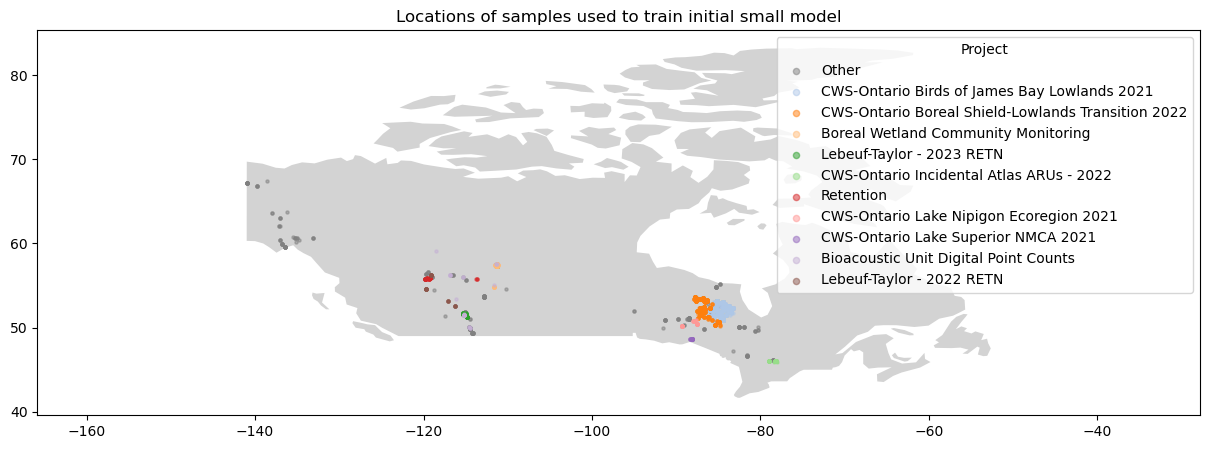

In [117]:
plot_locations(train_df.loc[train_ds.index], title="Locations of samples used to train initial small model")

### Remove the samples used to train this model from the training dataframe on disk. 
This is done because a future step involves using the model to clean out the mis-labelled items. If the model is presented with an item from the training set, it will have already learned the associated label and hence will be unable to reveal the mistake.

In [ ]:
# Remove the 2000 samples used to train this model from the training set on file
train_df.drop(train_ds.index, inplace=True)
train_df.target_present.value_counts()

target_present
0.0    35377
1.0     2303
Name: count, dtype: int64

# Save the reduced trainig set
The training set now contains 1000 fewer samples from each class than it did when we first made the train/valid split. 

In [ ]:
train_df.to_pickle(data_path / "interim" / "train_set" / "train_set.pkl")